In [1]:
# Import libraries 
from matplotlib import cycler
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import yfinance as yf

In [2]:
facecolor_theme = '#1f1f1f'

colors = cycler('color', 
                ['#669FEE', '#66EE91', '#9988DD', '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor = facecolor_theme)
plt.rc('axes', facecolor = facecolor_theme, edgecolor = '#1f1f1f',
       axisbelow = True, grid = True, prop_cycle = colors,
       labelcolor = 'white')
plt.rc('xtick', color = 'white')
plt.rc('ytick', direction = 'out', color = 'white')
plt.rc('legend', facecolor = facecolor_theme, edgecolor = facecolor_theme)
plt.rc('text', color = 'white')
plt.rc('figure', facecolor = facecolor_theme)

# Set grid lines to be thin
plt.rc('grid', linewidth=0.1, color='white')

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from binance import Client
from dotenv import load_dotenv
import os 

# Chargez les variables d'environnement à partir du fichier .env
load_dotenv()

# Accédez à vos clés d'API à l'aide de variables d'environnement
API_KEY = os.getenv("BINANCE_API_KEY")
SECRET_KEY = os.getenv("BINANCE_API_SECRET")

client = Client(API_KEY, SECRET_KEY) 

# Create function BackTest to evaluate the strategy in the later sections

In [21]:
def BackTest(serie, annualiazed_scalar=252):
  global serie_print

  # FUNCTION TO BUT THE RIGHT DATE FORMAT
  def date_format(df):
    df.index.name = "date_time"
    df = df.reset_index(drop=False)
    df['date_time'] = pd.to_datetime(df['date_time'])
    df['date_time'] = df['date_time'].dt.date
    df = df.set_index('date_time')

    return df
  
  def drawdown_function(serie):
    # We compute Cumsum of the returns
    cum = serie.dropna().cumsum() + 1

    # We compute max of the cumsum on the period (accumulate max)
    running_max = np.maximum.accumulate(cum)

    # We compute drawdown
    drawdown = cum/running_max - 1
    
    return drawdown

  # Import the benchmark
  sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
  
  # Change the name
  sp500.name = "SP500"

  try:
    # Concat the returns and the sp500
    val = pd.concat((serie,sp500), axis=1).dropna()

  except:
    # Put the right date format
    sp500 = date_format(sp500)
    serie = date_format(serie)

    # Concat the returns and the sp500
    val = pd.concat((serie,sp500), axis=1).dropna()

  # Compute the drawdown
  drawdown = drawdown_function(serie)*100
  
  # Compute max drawdown
  max_drawdown = -np.min(drawdown)

  # Put a subplots
  fig, (cum, dra) = plt.subplots(1,2, figsize=(20,6))
  
  # Put a Suptitle
  fig.suptitle("Backtesting", size=20)

  # Returns cumsum chart
  cum.plot(serie.cumsum()*100, color="#39B3C7")

  # SP500 cumsum chart
  cum.plot(val["SP500"].cumsum()*100, color="#B85A0F")
  
  # Horizontal line 
  cum.axhline(y=0, color='r', linewidth=0.5) 

  # Put a legend
  cum.legend(["Portfolio", "SP500"])
  
  # Set individual title
  cum.set_title("Cumulative Return", size=13)

  cum.set_ylabel("Cumulative Return %", size=11)

  # Put the drawdown
  dra.fill_between(drawdown.index,0,drawdown.values.flatten(), color="#C73954", alpha=0.65)

  # Set individual title
  dra.set_title("Drawdown", size=13)

  dra.set_ylabel("drawdown in %", size=11)
  
  # Horizontal line 
  dra.axhline(y=0, color='r', linewidth=0.5) 

  # Plot the graph
  plt.show()

  try:
    serie = serie["return"]
  except:
    pass
  
  serie_print = serie
  # Compute the sortino
  sortino = np.sqrt(annualiazed_scalar) * serie.mean()/serie.loc[serie<0].std()

  # Compute the beta
  beta = np.cov(val[["return", "SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)

  # Compute the alpha
  alpha = annualiazed_scalar * (serie.mean() - beta * serie.mean())

  # Print the statistics
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha*100,3)} %")
  try:
    print(f"MaxDrawdown: {np.round(max_drawdown[0],3)} %")
  except:
    print(f"MaxDrawdown: {np.round(max_drawdown,3)} %")
    
  

In [22]:
# Prepare the datas 
f = yf.download("GOOG", end="2021-01-01")
return_serie = f["Adj Close"].pct_change(1).dropna()
return_serie.name = "return"

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


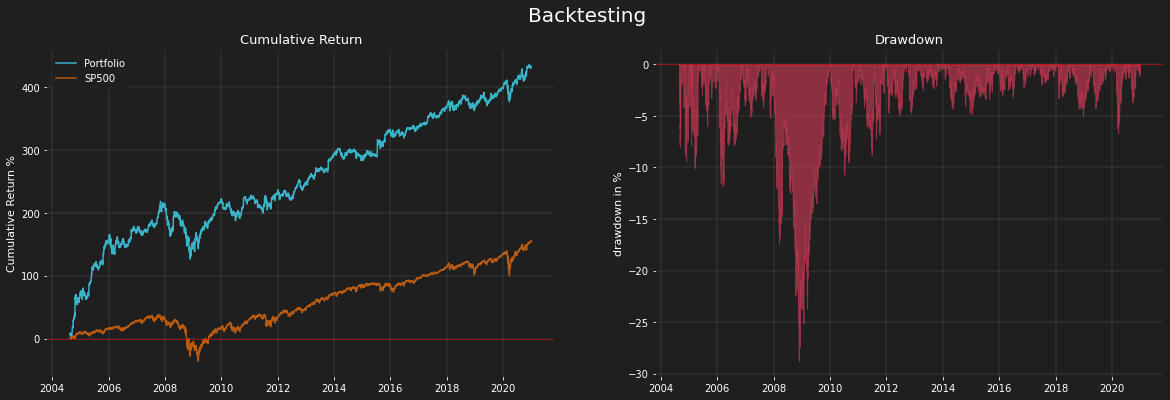

Sortino: 1.232
Beta: 0.965
Alpha: 0.918 %
MaxDrawdown: 28.78 %


In [23]:
BackTest(return_serie, 252)

# Application

In [ ]:
# Preprocessing function
def preprocessing(asset, interval):
    
    klines  = client.get_historical_klines(asset, interval)
    klines = [[x[0], float(x[1]), float(x[2]), float(x[3]),
              float(x[4]), float(x[5])] for x in klines]
    klines = pd.DataFrame(klines, columns =['date', 'open',
                                           'high', 'low', 
                                            'close', 'volume'])
    klines['date'] = pd.to_datetime(klines['date'], unit = 'ms')
    klines = klines.set_index('date')
    
    return klines

In [24]:
def preprocessing(asset):
    
    # Import data 
    df = yf.download(asset).dropna()
    
    # Rename columns 
    df.columns = ['open', 'high', 'low', 'close', 'adj close', 'volume']
    df.index.name = 'time'
    
    # Remove adj close 
    df = df.drop('adj close', axis=1)
    
    return df

In [25]:
def breakout(df, cost=0.01, duration=7):
    df['resistance'] = df['close'].rolling(30).max().shift(3)
    df['support'] = df['close'].rolling(30).min().shift(3)
    
    distance = 0.5 / 100 
    
    # Shift the values 
    df['Close Yesterday'] = df['close'].shift(1)    
    df['Resistance Yesterday'] = df['resistance'].shift(1)  
    df['signal_long'] = np.nan
    
    df.loc[(df['close'] > df['resistance'] * (1 + distance)) &\
           (df['Close Yesterday'] < df["Resistance Yesterday"]), 'signal_long'] = 1
    
    df['signal_long'] = df['signal_long'].fillna(value=0)
    
    # Compute the percentage of variation of the asset 
    df['pct'] = df['close'].pct_change(1)
    
    # Compute the return of the strategy 
    df['return'] = np.array([df['pct'].shift(1) for i in range(duration)]).sum(axis=0) * (df['signal_long'].shift(duration))
    
    df.loc[df['signal_long'] == 1, 'return'] = df['return'] - cost 
    
    return df['return']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


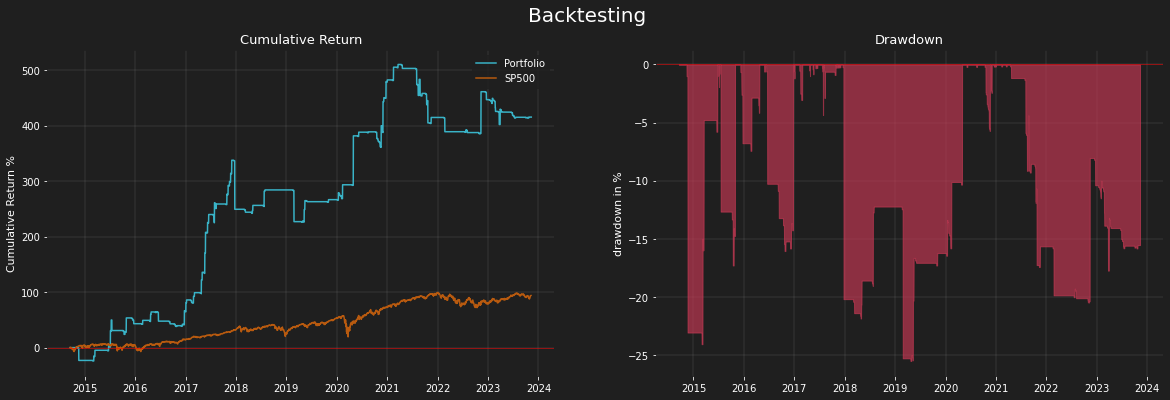

Sortino: 0.086
Beta: 0.041
Alpha: 6.196 %
MaxDrawdown: 25.509 %


In [26]:
asset = "BTC"
#interval = Client.KLINE_INTERVAL_1DAY   

# Manage the data
df = preprocessing(f"{asset}-USD")

# Create the strategy
dfc = breakout(df, duration=7)

# BackTesting
BackTest(dfc.fillna(value=0), 52)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


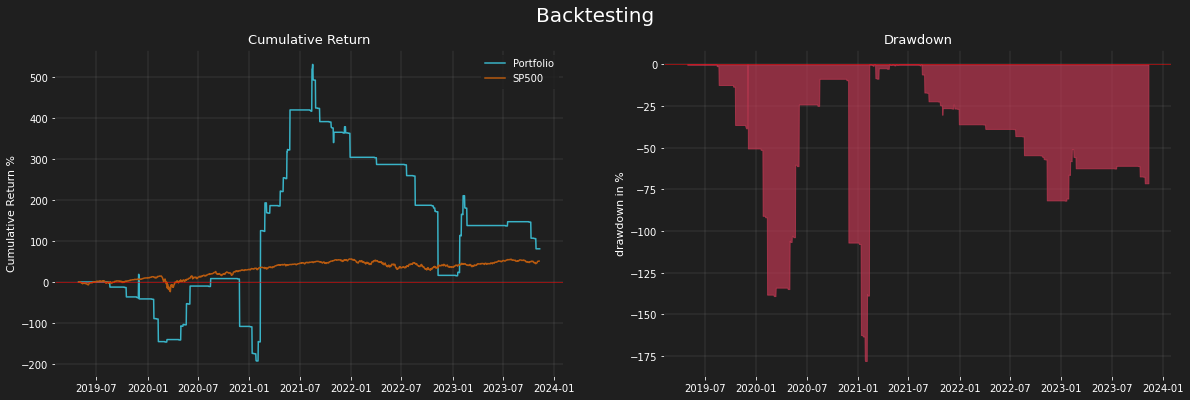

Sortino: 0.013
Beta: -0.302
Alpha: 3.307 %
MaxDrawdown: 177.893 %


In [27]:
asset = "MATIC"
#interval = Client.KLINE_INTERVAL_1DAY   

# Manage the data
df = preprocessing(f"{asset}-USD")

# Create the strategy
dfc = breakout(df, duration=7)

# BackTesting
BackTest(dfc.fillna(value=0), 52)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


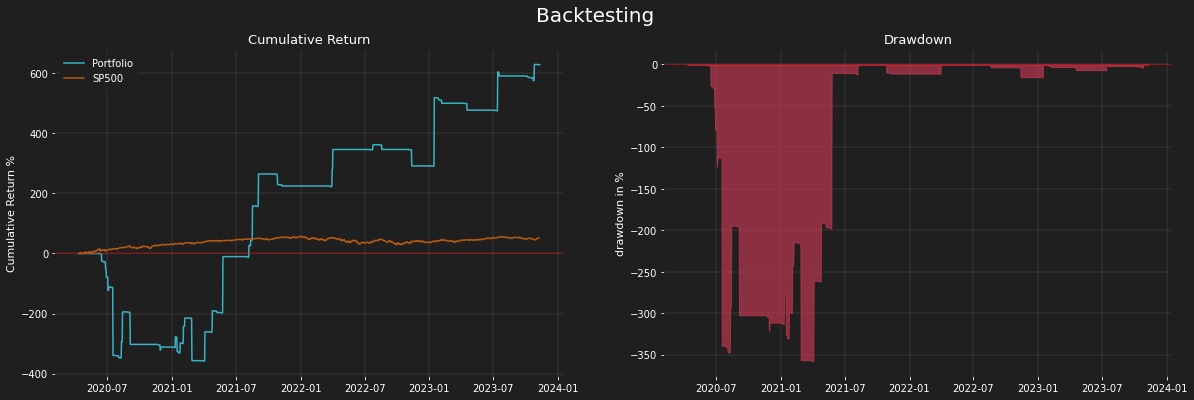

Sortino: 0.096
Beta: -0.04
Alpha: 25.931 %
MaxDrawdown: 357.562 %


In [28]:
asset = "SOL"
#interval = Client.KLINE_INTERVAL_1DAY   

# Manage the data
df = preprocessing(f"{asset}-USD")

# Create the strategy
dfc = breakout(df, duration=7)

# BackTesting
BackTest(dfc.fillna(value=0), 52)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


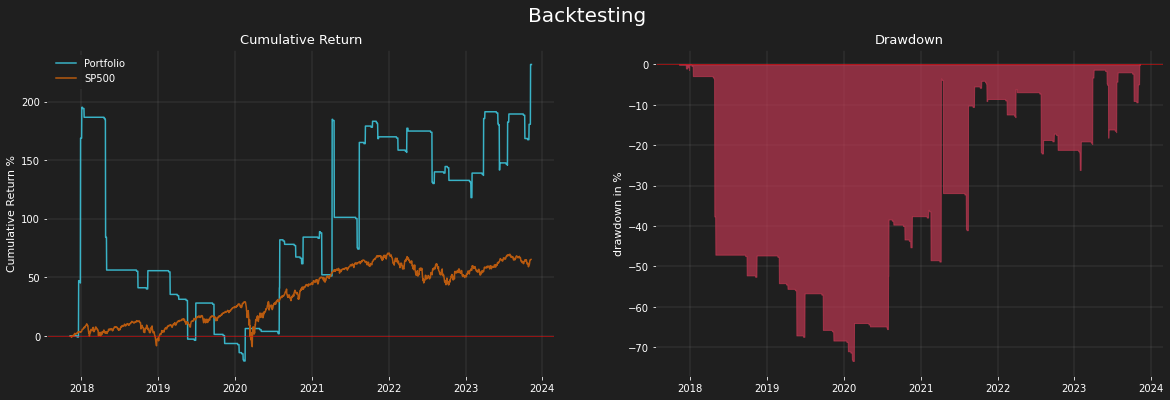

Sortino: 0.045
Beta: 0.0
Alpha: 5.495 %
MaxDrawdown: 73.385 %


In [35]:
asset = "XRP"
#interval = Client.KLINE_INTERVAL_1DAY   

# Manage the data
df = preprocessing(f"{asset}-USD")

# Create the strategy
dfc = breakout(df, duration=7)

# BackTesting
BackTest(dfc.fillna(value=0), 52)

# Sortino 

The **Sortino Ratio** is a statistic similar to the Sharpe Ratio with the same interpretation. However, the calculation is slightly different. In the Sortino Ratio, only the volatility of the negative gains is taken into account because that is what investors fear, not the bullish gains that generate profits.

- **Sortino Ratio < 0:** Not a profitable investment because your gains are negative.
- **Sortino Ratio < 1:** Profitable investment, but the risk of the investment is higher than the returns.
- **Sortino Ratio > 1:** Very good investment because the risk is lower than the returns.

$$ \text{Sortino Ratio} = \frac{R - \text{MAR}}{\sqrt{\text{Downside Deviation}}} $$


# Beta

The **beta** is a statistic that indicates the relationship between the variations of our portfolio and those of the market, which is represented by an index (for example, SP500).

- **abs(Beta) < 1:** It is good because it means that your portfolio has less variation than the index. (If beta=0.9, this means that if the index varies by 1, the portfolio varies by 0.9)
- **abs(Beta) > 1:** It is not a good thing because it means that your portfolio has a higher variation than the index. (If beta=1.1, this means that if the index varies by 1, the portfolio varies by 1.1)

*Note: `abs(-x) = x = abs(x)` (abs gives only the value of the variable, not the sign)*

$$ \beta = \frac{\text{Cov}(R_p, R_m)}{\text{Var}(R_m)} $$

# Alpha

**Alpha** is a statistic that indicates whether the portfolio outperforms the market in terms of risk and return.

- **Alpha > 0:** The portfolio outperforms the market in terms of risk and return.
- **Alpha < 0:** The portfolio underperforms the market in terms of risk and return.

$$ \alpha = R_p - (R_f + \beta \times (R_m - R_f)) $$